In [2]:
import numpy as np
import scipy as sp
from scipy.stats import qmc
import numpy.random as random
import vegas

In [3]:
class particle:
     def __init__(self, alive, mu, x, weight):
        self.alive = alive
        self.mu = mu
        self.x = x
        self.weight = weight

In [4]:
def mc_iso_vegas(sigmaS, sigmaA, q, L, x, mu, bias):
    sigmaT = sigmaS + sigmaA
    tally = np.zeros(2)
        
    #create particle
    p = particle(True, mu, x, q/W)

    while p.alive:
        #calculate distance to collision
        distance_to_collision = abs(-np.log(np.random.random())/sigmaT)

        #calculate distance to boundary
        if p.mu < 0:
            distance_to_boundary = abs(p.x/p.mu)
        elif p.mu >= 0:
            distance_to_boundary = (L-p.x)/p.mu

        #tally if distance to collision is greater than distance to boundary
        if distance_to_collision > distance_to_boundary:
            if p.mu < 0:
                tally[0] += p.weight
                p.alive = False
            elif p.mu >= 0:
                tally[1] += p.weight
                p.alive = False
        else:
            p.x += p.mu*distance_to_collision

            if np.random.random() < sigmaA/sigmaT: #absorbed
                p.alive = False
            else: #isotropic scatter
                p.mu = 2 * np.random.random() - 1

    #return weighted sum and tally
    left_bias = bias[0]
    right_bias = bias[1]
    return [left_bias*tally[0]+right_bias*tally[1], left_bias*tally[0], right_bias*tally[1]]

In [5]:
def mc_iso(sigmaS, sigmaA, q, W, L, N):
    sigmaT = sigmaS + sigmaA
    tally = np.zeros(2)   
        
    for i in range(N):
        #create particle
        x = W * np.random.random()
        mu = 2 * np.random.random() - 1 #mu between -1 and 1
        p = particle(True, mu, x, q)

        while p.alive:
            #calculate distance to collision
            distance_to_collision = abs(-np.log(np.random.random())/sigmaT)
            
            #calculate distance to boundary
            if p.mu < 0:
                distance_to_boundary = abs(p.x/p.mu)
            elif p.mu >= 0:
                distance_to_boundary = (L-p.x)/p.mu
        
            #tally if distance to collision is greater than distance to boundary
            if distance_to_collision > distance_to_boundary:
                if p.mu < 0:
                    tally[0] += p.weight
                    p.alive = False
                elif p.mu >= 0:
                    tally[1] += p.weight
                    p.alive = False
            else:
                p.x += p.mu*distance_to_collision
                
                if np.random.random() < sigmaA/sigmaT: #absorbed
                    p.alive = False
                else: #isotropic scatter
                    p.mu = 2 * np.random.random() - 1

    #return weighted sum and tally
    return [sum(tally)/N, tally[0]/N, tally[1]/N]

In [6]:
sigmaS = 5
sigmaA = 3
q = 3
L = 5
W = 3

tally = mc_iso(sigmaS, sigmaA, q, W, L, 100000)

print('Total leakage tally = ', tally[0])
print('Left leakage tally = ', tally[1])
print('Right leakage tally = ', tally[2])

print('ratio of leakage Left = ', round(tally[1]/tally[0], 4))
print('ratio of leakage Right = ', round(tally[2]/tally[0], 4))

Total leakage tally =  0.06402
Left leakage tally =  0.06402
Right leakage tally =  0.0
ratio of leakage Left =  1.0
ratio of leakage Right =  0.0


itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0707(36)      0.0707(36)          0.00     1.00
  2   0.072(10)       0.0709(34)          0.01     1.00
  3   0.0647(34)      0.0678(24)          0.27     0.95
  4   0.0615(35)      0.0657(20)          0.42     0.92
  5   0.0679(63)      0.0659(19)          0.33     0.98
  6   0.0656(34)      0.0659(17)          0.26     1.00
  7   0.0641(32)      0.0655(15)          0.23     1.00
  8   0.0617(25)      0.0645(13)          0.28     1.00
  9   0.0572(16)      0.06169(99)         0.78     0.77
 10   0.0668(32)      0.06214(95)         0.78     0.78

Total leakage =  0.06214(95)
Left leakage =  0.06214(95)
Right leakage =  0(0)
ratio of leakage Left =  1.00000000000(17)
ratio of leakage Right =  0(0)


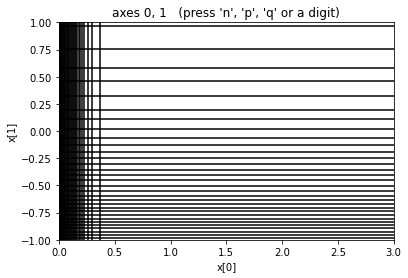

In [7]:
sigmaS = 5
sigmaA = 3
q = 3
L = 5
W = 3
bias = [.5,.5]

def f(x):
    return mc_iso_vegas(sigmaS, sigmaA, q, L, x[0], x[1], bias)
    
integ = vegas.Integrator([[0, W], [-1,1]])

result = integ(f, nitn=10, neval=10000)
print(result.summary())
print('Total leakage = ', result[0])
print('Left leakage = ', result[1])
print('Right leakage = ', result[2])

print('ratio of leakage Left = ', result[1]/result[0])
print('ratio of leakage Right = ', result[2]/result[0])
integ.map.show_grid(30)